# Classification and Regression, from linear and logistic regression to neural networks

## Regression:
Bring back regression code from project 1 (reference own work in bibliography) and compare to results from FFNN
Data can be:
- simple 1d
- then probably test with Franke before reading image data from cancer data set


## Classification:
Develop a logistic regression code and compare to FFNN.
Proposed data set:
- Wisconsin Breast Cancer Data (images representing various tumor features)
- Andre data (men pass på at kan diskutere resultatene mot literature)


## Part d) Classification analysis using neural networks

## Part e) Write your logistic regression code
To compare the FFNN code with logistic regression

## Part f) Critical evaluation of the various algorithms
Compare the results from the different algorithms, which works best for the regression case, and which one for classification? List pros and cons








## Part a) Write own Stochastic Gradient Descent Code: First step
Replace matrix inversion from OLS and Ridge with GD and SGD
Data can be either
- Franke
- Terrain 
- Recommended: something simple like for instance: f(x) = ao + a1x + a2x^2
look at exercises from week 41 for help

## Analyse the GD and SGD code. This should include:
(Lecture notes week 39 and 40 contain examples it is ok to use)
### 1: plain gradient descent with fixed learning rate (tune it) using the analytical expression for the gradient
### 2: Add momentum to the plain GD code and compare convergence with a fixed learning rate (may need to tune it). Keep using the analytical expression for the gradient
### 3: Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate (lectures week 39 and 40). Discuss the results as functions of the various parameters (size of batches, nr of epochs etc). Use the analytical gradient
### 4: Implement the adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD
### 5: Add RMSprop and Adam to your library of methods for tuning the learning rate
### 6: Replace thereafter your analytical gradient with either Autograd or JAX

In [13]:
from enum import Enum
from random import random, seed
import numpy as np

def MSE(expected_values, predicted_values):
    n = np.size(predicted_values)  # Number of data points
    return np.sum((expected_values - predicted_values)**2)/n

class LinearRegressionModel(Enum):
    OrdinaryLeastSquares = 0,
    Ridge = 1

class ScalingAlgorithm(Enum):
    GradientDescent = 0,
    MomentumGD = 1, #TODO: This is probably not relevant here anymore
    StochasticGD = 2,
    Adagrad = 3,
    RMSprop = 4,
    Adam = 5

class OLS_Hessian:
    def __init__(self, n, X):
        self.H = (2.0/n)* X.T @ X
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class Ridge_Hessian:
    def __init__(self, n, lmbda, XT_X):
        self.H = (2.0/n)* XT_X+2*lmbda* np.eye(XT_X.shape[0])
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class LinearRegression:
    def __init__(self, x, y):
        # Design matrix including the intercept
        # No scaling of data and all data used for training 
        n = x.shape[0]
        self.design_matrix = np.c_[np.ones((n, 1)), x, x*x]

        self.x = x
        self.y = y

        self.ols_hessian = None
        self.ridge_hessian = None
    
    def _grad(self, eta, gradient):
        return eta*gradient

    def _momentum_grad(self, eta, gradient, momentum, change):
        return eta*gradient + momentum*change

    def _adagrad(self, gradients, eta, G_iter):
        delta  = 1e-8 # AdaGrad parameter to avoid possible division by zero

        G_iter += gradients*gradients
        update = gradients*eta/(delta+np.sqrt(G_iter))

        return [update, G_iter]
    
    def gradient_descent_OLS(self, n, n_iterations, eta, scaling_algorithm = ScalingAlgorithm.GradientDescent, rho = None, momentum = None):
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ols_hessian:
            self.ols_hessian = OLS_Hessian(n, self.design_matrix)
        
        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ols_hessian.EigValues)
        change, G_iter = 0.0, np.zeros_like(beta)
        delta  = 1e-8

        for iter in range(n_iterations):
            gradient = (2.0/n)*self.design_matrix.T @ (self.design_matrix @ beta-self.y)
            match scaling_algorithm:
                case ScalingAlgorithm.GradientDescent:
                    beta -= self._grad(eta, gradient)

                case ScalingAlgorithm.MomentumGD:
                    new_change = self._momentum_grad(eta, gradient, momentum, change)
                    change = new_change
                    beta -= new_change

                case ScalingAlgorithm.Adagrad:
                    update, new_G_iter = self._adagrad(gradient, eta, G_iter)
                    G_iter = new_G_iter
                    if momentum:
                        update = momentum*change + update
                        change = update
                    beta -= update

                case ScalingAlgorithm.RMSprop:
                    if rho is None:
                        raise ValueError("Decay rate cannot be null when scaling with RMSprop")
                    
                    G_iter = rho*G_iter + (1-rho) * gradient**2
                    update = gradient*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update
                
                case _:
                    raise NotImplementedError()
                
            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    #Function contents taken from lecture notes
    def gradient_descent_ridge(self, n, n_iterations, eta, lmbda, momentum = None): 
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ridge_hessian:
            XT_X = self.design_matrix.T @ self.design_matrix
            self.ridge_hessian = Ridge_Hessian(n, lmbda, XT_X)
        
        #Id = n*lmbda* np.eye((XT_X).shape[0])

        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ridge_hessian.EigValues)
        change = 0.0
        for iter in range(n_iterations):
            gradient = 2.0/n*self.design_matrix.T @ (self.design_matrix @ beta-self.y)+2*lmbda*beta
            #Gradient descent with momentum:
            if momentum:
                new_change = eta*gradient + momentum*change
                change = new_change
                beta -= new_change

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))
            #Gradient descent without momentum:
            else:
                beta -= eta*gradient

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    def _learning_schedule(self, t):
        t0, t1 = 5, 50
        return t0/(t+t1)
    
    def _SGD(self, beta, lin_reg_model, epoch, M, m, scaling_algorithm = ScalingAlgorithm.StochasticGD, lmbda = None, rho = None, beta_values=None, momentum = None):
        G_iter = np.zeros_like(beta)
        change = np.zeros_like(beta) if momentum else None
        delta = 1e-8 #Constant for AdaGrad
        first_moment = np.zeros_like(beta)  # Initialize for Adam first moment
        second_moment = np.zeros_like(beta)  # Initialize for Adam second moment

        for iter in range(m):
            random_index = M*np.random.randint(m)
            xi = self.design_matrix[random_index:random_index+M]
            yi = self.y[random_index:random_index+M]

            y_tilde = xi @ beta
            gradients = (2.0/M)* xi.T @ (y_tilde-yi)

            match lin_reg_model:
                case LinearRegressionModel.Ridge:
                    if not lmbda:
                        raise ValueError("Lambda cannot be null for Ridge regression")
                    gradients += 2*lmbda*beta
            
            t = epoch*m+iter
            eta = self._learning_schedule(t)
            
            match scaling_algorithm:
                case ScalingAlgorithm.StochasticGD:
                    if momentum:
                        change = momentum*change - eta*gradients
                        beta += change
                    else:
                        beta -= eta*gradients

                case ScalingAlgorithm.Adagrad:
                    G_iter += gradients * gradients
                    update = gradients*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update

                case ScalingAlgorithm.RMSprop:
                    if rho is None:
                        raise ValueError("Decay rate cannot be null when scaling with RMSprop")
                    G_iter = rho*G_iter + (1-rho) * gradients**2
                    update = gradients*eta/(delta+np.sqrt(G_iter))
                    if momentum:
                        change = momentum*change - update
                        beta += change
                    else:
                        beta -= update
                
                case ScalingAlgorithm.Adam:
                    if beta_values is None:
                        raise ValueError("Beta values must be provided to run with ADAM")
                    
                    #From ChatGPT:
                    t += 1  # Increment time step
                    first_moment = beta_values[0] * first_moment + (1 - beta_values[0]) * gradients  # Update first moment
                    second_moment = beta_values[1] * second_moment + (1 - beta_values[1]) * gradients**2  # Update second moment

                    # Bias correction
                    first_term = first_moment / (1 - beta_values[0]**t)  # Corrected first moment
                    second_term = second_moment / (1 - beta_values[1]**t)  # Corrected second moment

                    update = eta * first_term / (np.sqrt(second_term) + delta)  # Update parameters

                    beta -= update
                    
                case _:
                    raise NotImplementedError()

        return beta

    
    def SGD_OLS(self, n_datapoints, batch_size, n_epochs, scaling_algorithm = ScalingAlgorithm.StochasticGD, rho = None, beta_values = None, momentum = None):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.OrdinaryLeastSquares, epoch, batch_size, m, scaling_algorithm, rho=rho, beta_values=beta_values, momentum=momentum)
            
            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))
        
        return [betas, scores]
    
    def SGD_Ridge(self, n_datapoints, batch_size, n_epochs, lmbda, scaling_algorithm = ScalingAlgorithm.StochasticGD):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.Ridge, epoch, batch_size, m, scaling_algorithm, lmbda)

            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]    

In [14]:
def Get_best_mse_and_eta(mse_data, learning_rates):
    min_mse = np.min(mse_data)
    best_index = np.argmin(mse_data)
    best_learning_rate = learning_rates[best_index]

    return [min_mse, best_learning_rate]

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Set-up taken from lecture notes
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+5*x*x + np.random.randn(n, 1)

N_iterations = 30

linear_regression = LinearRegression(x, y)

Best learning rate for OLS: 0.05 with MSE: 0.9497802399051559
Best learning rate for Ridge: 0.1 with MSE: 0.9592591797135442


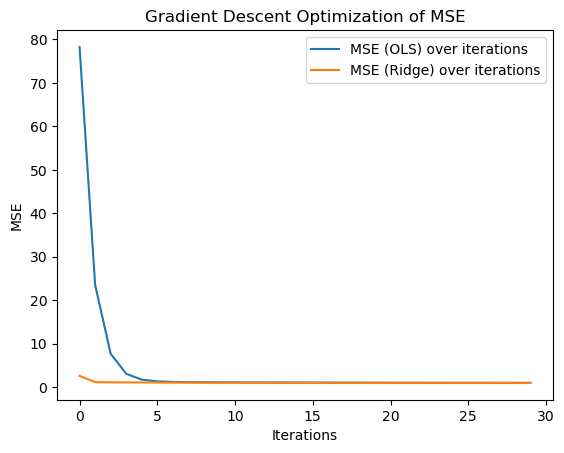

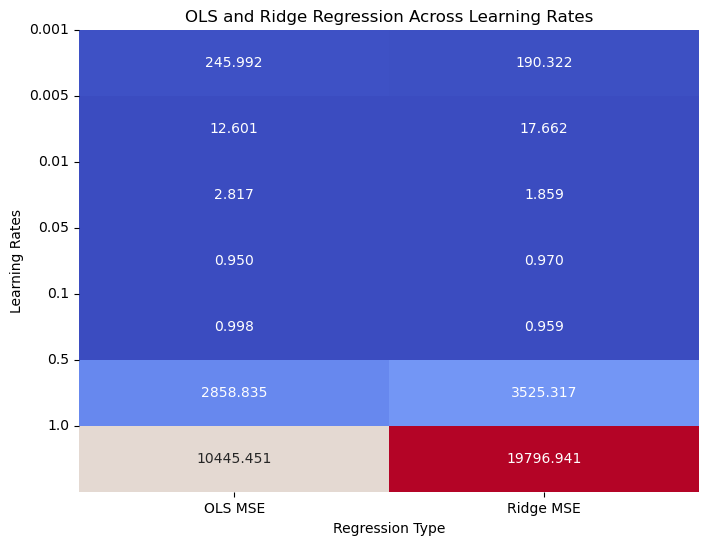

In [16]:
#Gradient descent
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
mse_data_test = list()
for i, eta in enumerate(learning_rates):
    ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, eta)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, eta, lmbda=0.01)
    mse_data[i, 1] = min(ridge_mses)

    # print(f"OLS - eta: {eta}, mse: {ols_mse}")
    # print(f"Ridge - eta: {eta}, mse: {ridge_mse}")


# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I'm lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, ols_best_eta)
ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, ridge_best_eta, lmbda=0.01)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE")
plt.legend()
plt.show()


# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Gradient descent with momentum
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
for i, eta in enumerate(learning_rates):
    #OLS
    ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, eta, ScalingAlgorithm.MomentumGD, momentum=momentum)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, eta, 0.01, momentum=momentum)
    mse_data[i, 1] = min(ridge_mses)

    #print(f"OLS - eta: {eta}, mse: {ols_mse}    Ridge - eta: {eta}, mse: {ridge_mse}")

# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I am lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent_OLS(n, N_iterations, ols_best_eta, ScalingAlgorithm.MomentumGD, momentum=momentum)
ridge_betas, ridge_mses = linear_regression.gradient_descent_ridge(n, N_iterations, ridge_best_eta, 0.01, momentum=momentum)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE")
plt.legend()
plt.show()

# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates w/ Memory")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




NameError: name 'momentum' is not defined

In [ ]:
#SGD with batches and epocs

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Test for different nr epochs
epochs = np.array([1, 10, 50, 100, 500, 1000])
#.. and batch size
batch_sizes = np.array([1, 5, 10, 20, 50])
mse_data_ols = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
mse_data_ridge = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
for j, M in enumerate(batch_sizes):
    for i, n_epochs in enumerate(epochs):
        beta_ols, scores_ols = linear_regression.SGD_OLS(n, M, n_epochs)
        mse_data_ols[j, i] = min(scores_ols)

        beta_ridge, scores_ridge = linear_regression.SGD_Ridge(n, M, n_epochs, lmbda=0.01)
        mse_data_ridge[j, i] = min(scores_ridge)

# Find the minimum MSE and corresponding indices for OLS
ols_min_mse_index = np.unravel_index(np.argmin(mse_data_ols, axis=None), mse_data_ols.shape)
ols_min_mse = mse_data_ols[ols_min_mse_index]
ols_best_mini_batch_size = batch_sizes[ols_min_mse_index[0]]
ols_best_n_epochs = epochs[ols_min_mse_index[1]]

# Find the minimum MSE and corresponding indices for Ridge
ridge_min_mse_index = np.unravel_index(np.argmin(mse_data_ridge, axis=None), mse_data_ridge.shape)
ridge_min_mse = mse_data_ridge[ridge_min_mse_index]
ridge_best_mini_batch_size = batch_sizes[ridge_min_mse_index[0]]
ridge_best_n_epochs = epochs[ridge_min_mse_index[1]]

# Print results
print(f"Best settings for OLS: Mini-batch size = {ols_best_mini_batch_size}, Epochs = {ols_best_n_epochs} with MSE: {ols_min_mse}")
print(f"Best settings for Ridge: Mini-batch size = {ridge_best_mini_batch_size}, Epochs = {ridge_best_n_epochs} with MSE: {ridge_min_mse}")

# Create a DataFrame for heatmap plotting
mse_df_ols = pd.DataFrame(mse_data_ols, index=batch_sizes, columns=epochs)
mse_df_ridge = pd.DataFrame(mse_data_ridge, index=batch_sizes, columns=epochs)


# Plot the heatmap
plt.figure(figsize=(14, 6))

# OLS MSE Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(mse_df_ols, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("OLS MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

# Ridge MSE Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(mse_df_ridge, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Ridge MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

plt.tight_layout()
plt.show()


In [ ]:
#Adagrad
n = 100
n_iterations = 1000
eta = 0.1
momentum = 0.3
batch_size = 5
epochs = 100

#Regular adagrad
ada_betas, ada_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.Adagrad)
print(f"Best GD AdaGrad: {min(ada_mses)}")

#Adagrad with momentum
ada_betas, ada_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.Adagrad, momentum)
print(f"Best GD AdaGrad with momentum: {min(ada_mses)}")

#SGD with AdaGrad
ada_betas, ada_mses = linear_regression.SGD_OLS(n, batch_size, epochs, ScalingAlgorithm.Adagrad)
print(f"Best SGD AdaGrad: {min(ada_mses)}")

#SGD with AdaGrad and momentum
ada_betas, ada_mses = linear_regression.SGD_OLS(n, batch_size, epochs, ScalingAlgorithm.Adagrad, momentum=momentum)
print(f"Best SGD AdaGrad with momentum: {min(ada_mses)}")

#For comparison
#GD:
gd_betas, gd_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.GradientDescent)
print(f"Best GD: {min(gd_mses)}")

#GD with momentum:
gd_betas, gd_mses = linear_regression.gradient_descent_OLS(n, n_iterations, eta, ScalingAlgorithm.GradientDescent, momentum=momentum)
print(f"Best GD with momentum: {min(gd_mses)}")

#SGD:
sgd_betas, sgd_mses = linear_regression.SGD_OLS(n, batch_size, epochs)
print(f"Best SGD: {min(sgd_mses)}")

#SGD with momentum:
sgd_betas, sgd_mses = linear_regression.SGD_OLS(n, batch_size, epochs, momentum=momentum)
print(f"Best SGD with momentum: {min(sgd_mses)}")

In [ ]:
#RMSprop
betas, rms_prop_mses = linear_regression.gradient_descent_OLS(n=100, n_iterations=1000, eta=0.1, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9)
print(f"Best GD RMSprop: {min(rms_prop_mses)}")

#RMSprop with momentum
betas, rms_prop_mses = linear_regression.gradient_descent_OLS(n=100, n_iterations=1000, eta=0.1, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9, momentum=0.9)
print(f"Best GD RMSprop with momentum: {min(rms_prop_mses)}")

#SGD with RMSprop
betas, rms_prop_mses = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9)
print(f"Best SGD RMSprop: {min(rms_prop_mses)}")

#SGD with RMSprop with momentum
betas, rms_prop_mses = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.RMSprop, rho=0.9, momentum=0.9)
print(f"Best SGD RMSprop with momentum: {min(rms_prop_mses)}")

#SGD with ADAM
betas, rms_prop_mses = linear_regression.SGD_OLS(n_datapoints=100, batch_size=5, n_epochs=100, scaling_algorithm=ScalingAlgorithm.Adam, beta_values=[0.9, 0.999])
print(f"Best SGD ADAM: {min(rms_prop_mses)}")


## Part b) Writing your own neural network code (Central part of the project)
Implement back propagation algorithm discussed in lectures week 41 and 42
### Regression problem first: Can use simple 2nd order poly from part a, Franke or terrain. Discuss choice of cost fcn
- Decide on cost fcn
- With Sigmoid as activation fcn for hidden layers, and a flexible nr of hidden layers, write an FFNN
- Initialise wheights using a normal distribution
- How would you initialise the biases?
- Which activation would you choose for the final output layer?
- Train your network

If running on Franke:
- compare your results from OLS and Ridge from project 1 (if using franke or terrain)

But also:
- Compare to similar code in scikit
Comment on results and compare linear regression to this FFNN
Make an analysis of the regularisation parameters and the learning rates employed to find the optimal MSE and R2 scores.


In [ ]:
import numpy as np
import NeuralNetwork as nn
# We use the Sigmoid function as activation function

# ensure the same random numbers appear every time
np.random.seed(0)
# Input variable
x = np.array([4.0],dtype=np.float64)
# Target values
y = 2*x+1.0 
y += np.random.normal(0, 100, y.shape)

# Defining the neural network, only scalars here
n_inputs = x.shape
n_features = 1
n_hidden_neurons = 1
n_outputs = 1

n_iterations = 50
#TODO: Some stopping condition

#Set up and train simple model
model = nn.NeuralNetwork(nn.CostFunction.MSE)
epochs, loss = model.train(x, y, n_iterations, learning_rate=0.1)

print(f"Epoch {epochs}, Loss: {loss}")


In [ ]:
#Compare to scikit learn
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

import NeuralNetwork as nn

# 1. Generate synthetic data for regression
# Ensure the same random numbers appear every time
np.random.seed(0)

X, y = make_regression(n_samples=100, n_features=1, noise=10)

# 2. Initialize and fit the Scikit-learn MLPRegressor
scikit_model = MLPRegressor(hidden_layer_sizes=(1,),
                             activation='logistic',
                             learning_rate_init=0.001,
                             max_iter=50,
                             random_state=0)

scikit_model.fit(X, y)

# 3. Predictions and evaluation using Scikit-learn
y_pred_sklearn = scikit_model.predict(X)
mse_sklearn = mean_squared_error(y, y_pred_sklearn)
print(f"Mean Squared Error with Scikit-learn: {mse_sklearn}")

# 4. Initialize and train custom neural network
hidden_layers = list([nn.HiddenLayer(nn.ActivationFunction.Sigmoid, n_features=1, n_hidden_neurons=5)])
custom_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_layers=hidden_layers)

epoch, loss = custom_model.train(X, y.reshape(-1, 1), epochs=50, learning_rate=0.001)  # Reshape y to match expected input
print(f"Mean Squared Error with custom neural net: {loss}")

#TODO: Change different params and study the results
# iterations = 300
# for iter in iterations:
    

## Part c) Testing different activation functions for the hidden layers
- Sigmoid
- RELU
- Leaky RELU
Discuss the results
May also study the way you initialise the  weights and biases

In [ ]:
import numpy as np
import NeuralNetwork as nn

#Same set up as before
np.random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += np.random.normal(0, 100, y.shape)

eta = 0.1
#RELU verbosity test:
relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=1)
epoch, loss = relu_model.train(x, y, epochs=50, learning_rate=eta, verbosity=True)
print(f"Eta: {eta} - RELU loss after {epoch} iterations: {loss}")



Epoch 1, Loss: 30572.95723283121
Epoch 2, Loss: 3160510195.3454704
Epoch 3, Loss: 33521339.609275833
Epoch 4, Loss: 27152285.083513428
Epoch 5, Loss: 21993350.917645875
Epoch 6, Loss: 17814614.24329316
Epoch 7, Loss: 14429837.53706746
Epoch 8, Loss: 11688168.40502464
Epoch 9, Loss: 9467416.408069959
Epoch 10, Loss: 7668607.290536667
Epoch 11, Loss: 6211571.905334699
Epoch 12, Loss: 5031373.243321106
Epoch 13, Loss: 4075412.327090095
Epoch 14, Loss: 3301083.9849429764
Epoch 15, Loss: 2673878.027803811
Epoch 16, Loss: 2165841.2025210867
Epoch 17, Loss: 1754331.3740420805
Epoch 18, Loss: 1421008.412974085
Epoch 19, Loss: 1151016.814509009
Epoch 20, Loss: 932323.6197522973
Epoch 21, Loss: 755182.1319993609
Epoch 22, Loss: 611697.5269194823
Epoch 23, Loss: 495474.9968047807
Epoch 24, Loss: 401334.74741187243
Epoch 25, Loss: 325081.1454036166
Epoch 26, Loss: 263315.7277769295
Epoch 27, Loss: 213285.73949931288
Epoch 28, Loss: 172761.44899444346
Epoch 29, Loss: 139936.7736854992
Epoch 30, Los

Eta: 0.1 - Sigmoid loss after 50 iterations: 1.07382691027876e-05
Eta: 0.1 - RELU loss after 50 iterations: 2217.0732650228265
Eta: 0.1 - Leaky RELU loss after 50 iterations: nan

Eta: 0.01 - Sigmoid loss after 50 iterations: 4657.734629657068
Eta: 0.01 - RELU loss after 50 iterations: 14045.388489276196
Eta: 0.01 - Leaky RELU loss after 50 iterations: nan

Eta: 0.001 - Sigmoid loss after 50 iterations: 27719.61596028487
Eta: 0.001 - RELU loss after 50 iterations: 9.338093633899414e-25
Eta: 0.001 - Leaky RELU loss after 50 iterations: 9.338093633899414e-25

Eta: 0.0001 - Sigmoid loss after 50 iterations: 33070.54105177025
Eta: 0.0001 - RELU loss after 50 iterations: 1.1496797634393203
Eta: 0.0001 - Leaky RELU loss after 50 iterations: 1.1496797634393203



/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:38: RuntimeWarning: overflow encountered in square
  return np.sum((y_target - y_pred)**2)/n
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:111: RuntimeWarning: overflow encountered in matmul
  delta = np.matmul(delta_output, self.output_layer.get_weights().T) * self.hidden_layers[-1].derivative(activations[-2])
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:112: RuntimeWarning: overflow encountered in matmul
  output_weights_gradient = np.matmul(activations[-2].T, delta_output)
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:132: RuntimeWarning: invalid value encountered in subtract
  self.output_layer.w -= learning_rate * output_weights_gradient
/Users/helle/Documents/UiO/Fys-Stk4155/Project2/NeuralNetwork.py:137: RuntimeWarning: invalid value encountered in subtract
  layer.w -= learning_rate * hidden_weights_gradient[i]
/Users/helle/Documents/UiO/Fys-Stk4155/Project

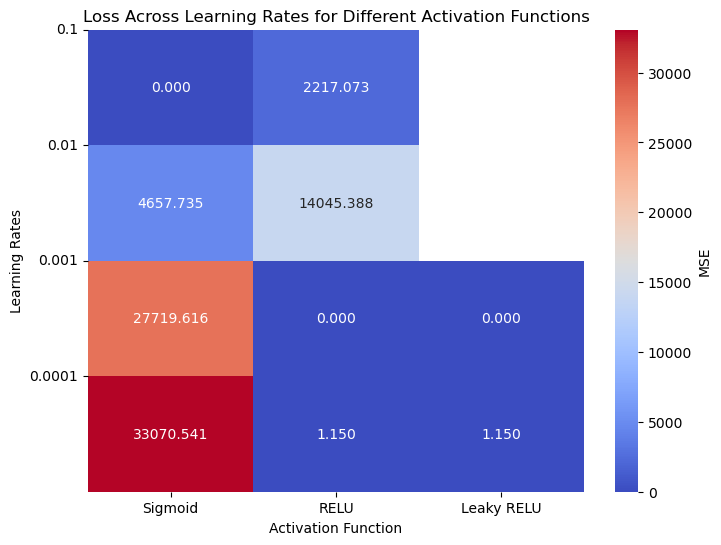

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

learning_rates = [0.1, 0.01, 0.001, 0.0001]
for eta in learning_rates:
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(nn.CostFunction.MSE, random_state=0)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(x, y, epochs=50, learning_rate=eta)
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {eta} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0)
    epoch, loss_relu = relu_model.train(x, y, epochs=50, learning_rate=eta)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {eta} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0)
    epoch, loss_leaky = leaky_relu_model.train(x, y, epochs=50, learning_rate=eta)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {eta} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()

#TODO: Look at init bias and weights, and if those should be different for different activations
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Learning Rates for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=loss_df.index, rotation=0)
plt.show()



[[1.76405235]]
Eta: 0.0001 - Sigmoid loss after 10 iterations: 607.7377122508896
Eta: 0.0001 - RELU loss after 10 iterations: 0.016218356378536733
Eta: 0.0001 - Leaky RELU loss after 10 iterations: 0.016218356378536733

[[0.09120472]]
Eta: 0.0001 - Sigmoid loss after 10 iterations: 683.7357305528974
Eta: 0.0001 - RELU loss after 10 iterations: 92.39923784626373
Eta: 0.0001 - Leaky RELU loss after 10 iterations: 92.39923784626373

[[-0.71239066]]
Eta: 0.0001 - Sigmoid loss after 10 iterations: 5159.277246449361
Eta: 0.0001 - RELU loss after 10 iterations: 33761.58064286303
Eta: 0.0001 - Leaky RELU loss after 10 iterations: 33753.10065130291

[[0.49671415]]
Eta: 0.0001 - Sigmoid loss after 10 iterations: 634.5468341784725
Eta: 0.0001 - RELU loss after 10 iterations: 2.189024876396196
Eta: 0.0001 - Leaky RELU loss after 10 iterations: 2.189024876396196

[[-1.74976547]]
Eta: 0.0001 - Sigmoid loss after 10 iterations: 5159.516896757441
Eta: 0.0001 - RELU loss after 10 iterations: 33761.5806

/var/folders/16/vv67yqq12653l08qz2zn9sd80000gn/T/ipykernel_75001/548815636.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intial_weights[i] = np.round(w, 2)


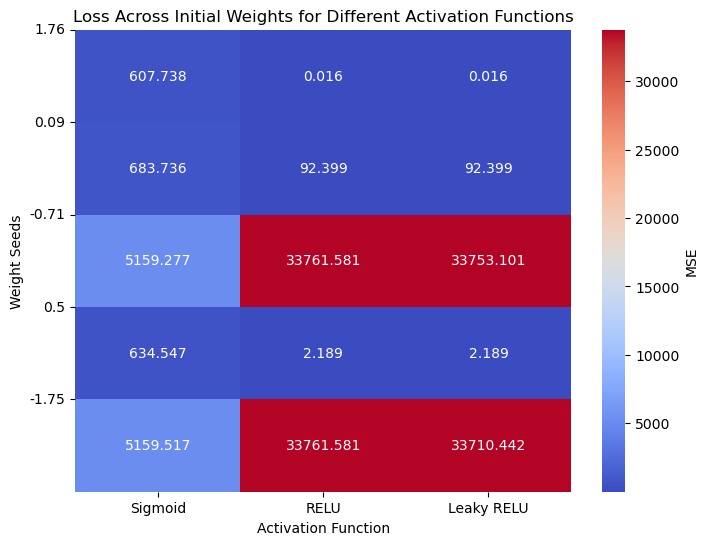

In [31]:
#Picking the best learning rates for each model, test different initial weight seeds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

weight_seeds = [0, 8, 13, 42, 100]
intial_weights = np.zeros(len(weight_seeds))
for i, seed in enumerate(weight_seeds):
    np.random.seed(seed)
    w = np.random.randn(1, 1)
    print(w)
    intial_weights[i] = np.round(w, 2)
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(nn.CostFunction.MSE, random_state=seed)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(x, y, epochs=10, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {eta} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=seed)
    epoch, loss_relu = relu_model.train(x, y, epochs=10, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {eta} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=seed)
    epoch, loss_leaky = leaky_relu_model.train(x, y, epochs=10, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {eta} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=intial_weights) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Initial Weights for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Weight Seeds")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(intial_weights)), labels=loss_df.index, rotation=0)
plt.show()




Eta: 0.001 - RELU loss after 5 iterations: 9.54776823191088
Eta: 0.001 - Leaky RELU loss after 5 iterations: 9.54776823191088

Eta: 0.001 - RELU loss after 5 iterations: 9.335743774369796
Eta: 0.001 - Leaky RELU loss after 5 iterations: 9.335743774369796

Eta: 0.001 - RELU loss after 5 iterations: 8.919617826247801
Eta: 0.001 - Leaky RELU loss after 5 iterations: 8.919617826247801

Eta: 0.001 - RELU loss after 5 iterations: 7.545650179869769
Eta: 0.001 - Leaky RELU loss after 5 iterations: 7.545650179869769

Eta: 0.001 - RELU loss after 5 iterations: 2.0315012754985493
Eta: 0.001 - Leaky RELU loss after 5 iterations: 2.0315012754985493

Eta: 0.001 - RELU loss after 5 iterations: 0.03972410537603903
Eta: 0.001 - Leaky RELU loss after 5 iterations: 0.03972410537603903



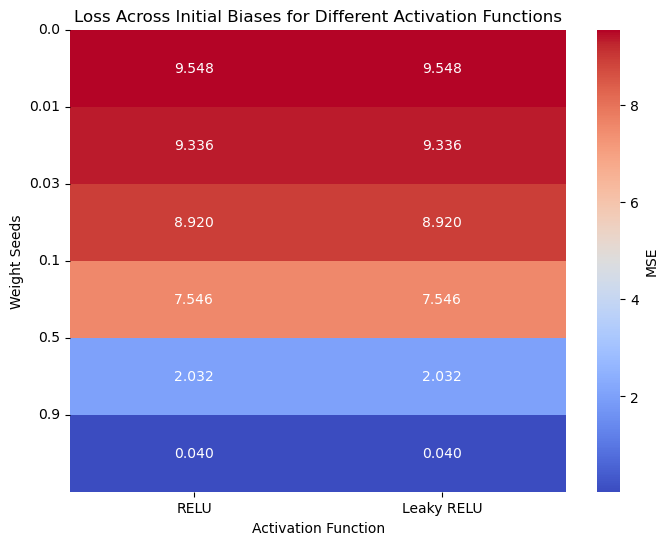

In [9]:
#Picking the best learning rates for each model, test different initial bias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

#Skipping Sigmoid here as it needs a lot more iterations in order to get to zero
loss_data = {
    #"Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

initial_bias = [0, 0.01, 0.03, 0.1, 0.5, 0.9]
for bias in initial_bias:
    #Sigmoid:
    # sigmoid_model = nn.NeuralNetwork(nn.CostFunction.MSE, random_state=0, hidden_bias=bias, output_bias=bias)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    # epoch, loss_sigmoid = sigmoid_model.train(x, y, epochs=5, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    # loss_data["Sigmoid"].append(loss_sigmoid)

    # print(f"Eta: {0.1} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0, hidden_bias=bias, output_bias=bias)
    epoch, loss_relu = relu_model.train(x, y, epochs=5, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {0.001} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0, hidden_bias=bias, output_bias=bias)
    epoch, loss_leaky = leaky_relu_model.train(x, y, epochs=5, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {0.001} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=initial_bias) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Initial Biases for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Weight Seeds")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(initial_bias)), labels=loss_df.index, rotation=0)
plt.show()




Eta: 0.1 - Sigmoid loss after 1 iterations: 33724.31081658976
Eta: 0.001 - RELU loss after 1 iterations: 29060.04298205365
Eta: 0.001 - Leaky RELU loss after 1 iterations: 29060.04298205365

Eta: 0.1 - Sigmoid loss after 3 iterations: 13815.849756335116
Eta: 0.001 - RELU loss after 3 iterations: 6536.387809599806
Eta: 0.001 - Leaky RELU loss after 3 iterations: 6536.387809599806

Eta: 0.1 - Sigmoid loss after 8 iterations: 1483.492976803453
Eta: 0.001 - RELU loss after 8 iterations: 0.0007805584779962602
Eta: 0.001 - Leaky RELU loss after 8 iterations: 0.0007805584779962602

Eta: 0.1 - Sigmoid loss after 10 iterations: 607.6399627678586
Eta: 0.001 - RELU loss after 10 iterations: 5.671208533576012e-05
Eta: 0.001 - Leaky RELU loss after 10 iterations: 5.671208533576012e-05

Eta: 0.1 - Sigmoid loss after 30 iterations: 0.08077015197264922
Eta: 0.001 - RELU loss after 30 iterations: 2.3306930558814135e-16
Eta: 0.001 - Leaky RELU loss after 30 iterations: 2.3306930558814135e-16

Eta: 0.1 -

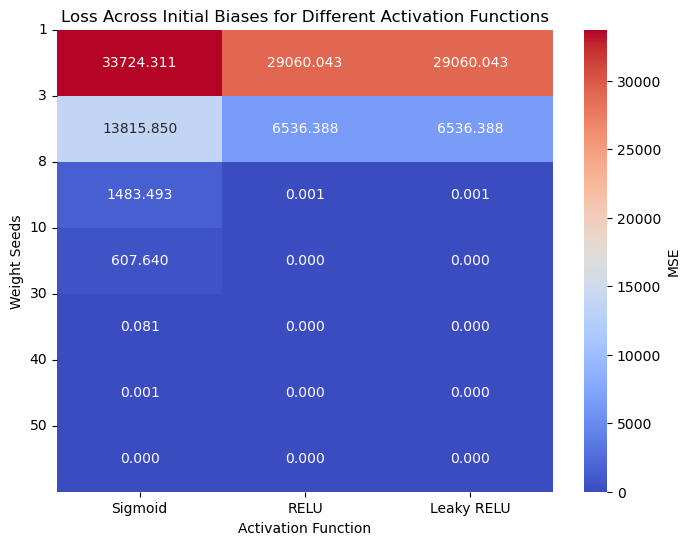

In [10]:
#Picking the best learning rates for each model, test different nr of iterations
#TODO: Should really just run it once and get an output for each iteration and plot as a graph as seen in a, but then need to store output in the model, and can't be arsed right now

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import NeuralNetwork as nn

#Same set up as before
random = np.random
random.seed(0)
x = np.array([4.0],dtype=np.float64)
y = 2*x+1.0 
y += random.normal(0, 100, y.shape)

#Skipping Sigmoid here as it needs a lot more iterations in order to get to zero
loss_data = {
    "Sigmoid": [],
    "RELU": [],
    "Leaky RELU": []
}

n_iterations = [1, 3, 8, 10, 30, 40, 50]
for n_iter in n_iterations:
    #Sigmoid:
    sigmoid_model = nn.NeuralNetwork(nn.CostFunction.MSE, random_state=0, hidden_bias=bias)   #Sets a random seed so we get the same initial weights for each model and initial learning rate
    epoch, loss_sigmoid = sigmoid_model.train(x, y, epochs=n_iter, learning_rate=0.1) #Reducing nr of epochs to get more variation in results
    loss_data["Sigmoid"].append(loss_sigmoid)

    print(f"Eta: {0.1} - Sigmoid loss after {epoch} iterations: {loss_sigmoid}")

    #RELU:
    relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.RELU, random_state=0, hidden_bias=bias, output_bias=0.9)
    epoch, loss_relu = relu_model.train(x, y, epochs=n_iter, learning_rate=0.001)
    loss_data["RELU"].append(loss_relu)

    print(f"Eta: {0.001} - RELU loss after {epoch} iterations: {loss_relu}")

    #LeakyRELU:
    leaky_relu_model = nn.NeuralNetwork(nn.CostFunction.MSE, hidden_activation=nn.ActivationFunction.LeakyRELU, random_state=0, hidden_bias=bias, output_bias=0.9)
    epoch, loss_leaky = leaky_relu_model.train(x, y, epochs=n_iter, learning_rate=0.001)
    loss_data["Leaky RELU"].append(loss_leaky)

    print(f"Eta: {0.001} - Leaky RELU loss after {epoch} iterations: {loss_leaky}")
    print()
#TODO: Set a stop condition and see which one reaches an answer the quickest
    

# Create a DataFrame from the collected loss data
loss_df = pd.DataFrame(loss_data, index=n_iterations) #TODO: This should really be the actual initial weight nrs

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(loss_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Loss Across Initial Biases for Different Activation Functions")
plt.xlabel("Activation Function")
plt.ylabel("Weight Seeds")
plt.xticks(ticks=np.arange(0.5, len(loss_df.columns)), labels=loss_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(n_iterations)), labels=loss_df.index, rotation=0)
plt.show()


